In [48]:
import pandas as pd
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import load_wine
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, \
normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#wine dataset is not the same as wine quality dataset
wine = load_wine()
data = pd.DataFrame(wine.data, columns=wine.feature_names)

X = data
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


## DBSCAN
### Parameters
#### eps
how close do points need to be to be considered neighbors.
- small eps -> many points labeled as noise
- large eps -> clusters merge together
#### min_samples
how many points are needed to form a dense region
- small -> sensitive to noise
- large -> stricter clusters, more noise
rule of thumb:
min_samples >= number of features + 1

### Step 1: always scale the data
DBSCAN is distance-based. If we skip this, eps is meaningless

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Step 2: Choose min_samples
we usually fix min_samples, then tune eps
Typical values:
- 2D toy data -> 4-6
- medium real data -> 5-10
- wine (13 features) -> 14-20

In [4]:
#example
min_samples = X.shape[1] + 1

### Step 3: Find eps using the k-distance plot
This is the DBSCAN equivalent of elbow
How it works:
- for each point, compute distance to its k-th nearest neighbor
- sort these distances
- look for a knee/bend

We use nearest neighbors method to find a predefined number of training samples closest in distance to the new point.

In [5]:
k = min_samples

neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

k_distances = np.sort(distances[:,-1])

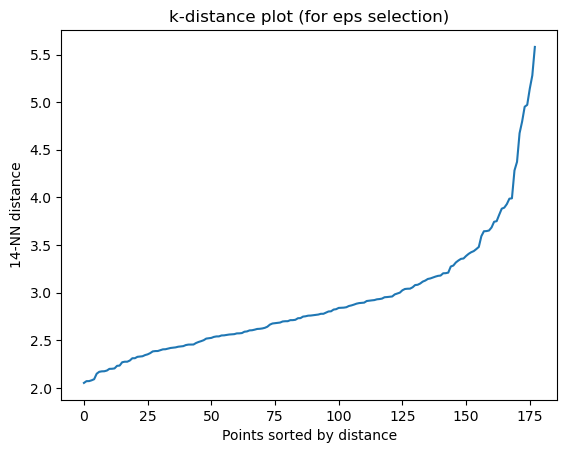

In [6]:
plt.plot(k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f"{k}-NN distance")
plt.title('k-distance plot (for eps selection)')
plt.show()

How to read it:
- flat region -> dense point
- sharp rise -> transition to noise
- eps = where the curve bends

### Step 4: Fit DBSCAN

In [27]:
dbscan = DBSCAN(eps=3.5, min_samples = min_samples)
labels = dbscan.fit_predict(X_scaled)

In [28]:
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int64)

### Step 5: Tuning DBSCAN
DBSCAN does not have one perfect parameter set

In [37]:
#generate 10 values with equal intervals between 0.3 to 1.2
eps_values = np.linspace(3.0, 4.0, 10)
min_samples_values = [5,10,15]

results = []

for eps in eps_values:
    for mins in min_samples_values:
        db = DBSCAN(eps = eps, min_samples = mins)
        labels = db.fit_predict(X_scaled)
        #skip trivial results
        if len(set(labels)) <= 1 or (-1 in set(labels) and len(set(labels)) <=2):
            continue
    results.append((eps, mins, labels))

the skipping trivial results is there to remove useless data. If there is only 1 unique label "len(set(labels))", then it is only {-1} which is all noise or {0} which means 1 giant cluster, useless results. The second condition means noise exists and total unique labels is 2, so the only possible cases are {0, -1} or {-1} which also useless.

So the code means if DBSCAN produces no clusters, one cluster, or only a cluster + noise, then skip this parameter combination

In [34]:
results

[(3.0,
  15,
  array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,
         -1, -1,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0], dtype=int64)),
 (3.111111111111111,
  15,
  array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

### Step 7: Evaluate DBSCAN
Check for:
- number of clusters
- % of noise points
- stability across eps values
- interpretability

In [35]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
noise_ratio = np.mean(labels == -1)

In [36]:
print(n_clusters, noise_ratio)

1 0.033707865168539325


### Summary
Even though the steps are already good enough to implement DBSCAN, the wine dataset is not the best dataset to use for DBSCAN because of its high dimensionality (14D+). DBSCAN works best for 2-3D, so most of the time PCA or dimensionality reduction will be required.

## Hierarchical
We should use hierarchical when:
- we don't know the number of clusters upfront
- we want interpretability (tree structure / dendogram)
- dataset is small to medium (usually < 10k to 20k rows)

Unlike K-Means it is not iterative. Unlike DBSCAN it always assigns every point (no noise)

### Step 1: Scale features
Same rules as others, features scaling is a must

In [38]:
X_scaled = scaler.fit_transform(X)

### Step 2: Choose distance + linkage
Linkage = the rule for measuring distance between two clusters when merging them. Linkage defines how distance between clusters is computed.

#### Common linkages:
##### Ward
it minimizes increase of variance within a cluster
- tries to keep clusters compact & spherical
- very similar to k-means
- great for numeric & scaled data
##### Average
it uses average pairwise distance between all points in two clusters
- more flexible cluster shapes
- merge clusters more smoothly
- great for balanced merges and medium number of k (5+)
##### Complete
it uses maximum distance between point in clusters
- forces very tight clusters
- sensitive to outliers
- great to make compact clusters where noise is minimal
##### Single (usually avoid)
it uses minimum distance
- causes chaining
- poor cluster quality most of the time

### Step 3: Build Dendogram
This is simlar to choosing k in K-Means

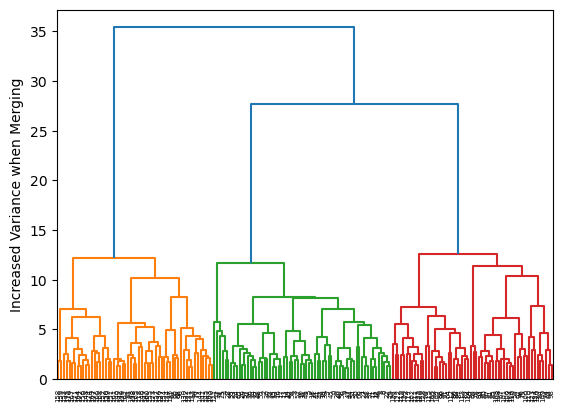

In [45]:
z = linkage(X_scaled, method = 'ward')
dendrogram(z)
plt.ylabel("Increased Variance when Merging")
plt.show()

What we're looking for is big vertical jumps when two clusters merged, because that means the two are very different and merging them would increase cluster variance a lot. For this case, the big jumps happened when it tried to merge into two clusters, meaning visually we should choose 3 clusters

### Step 4: Choose number of clusters

In [49]:
hc = AgglomerativeClustering(n_clusters = 3, linkage='ward')
labels = hc.fit_predict(X_scaled)

In [51]:
data['hier_cluster'] = labels
data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,hier_cluster
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,2
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,2
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,2
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,2
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,2


In [52]:
data.hier_cluster.value_counts()

hier_cluster
2    64
0    58
1    56
Name: count, dtype: int64

The result is pretty similar to K-Means clustering

### Step 5: Evaluation (same metrics as K-Means)
Hierarchical does not optimize an objective, so evaluation is critical

In [53]:
sil_score = silhouette_score(X_scaled, data['hier_cluster'])
dav_score = davies_bouldin_score(X_scaled, data['hier_cluster'])

print('Sil_Score', sil_score)
print('Davies Score', dav_score)

Sil_Score 0.2774439826952266
Davies Score 1.4185919431857326


### Step 6: Stability Check
Because hierarchical is deterministic, meaning same data + same parameters equals exactly the same clustering every time, thus no random initializaiton. To check stability:
- change linkage
- change distance metric

If cluster structure collapses, it is not robust

In [54]:
for k in [3,4,5]:
    for link in ['ward', 'average']:
        labels = AgglomerativeClustering(n_clusters = k, linkage=link).fit_predict(X_scaled)
        print(k, silhouette_score(X_scaled, labels))

3 0.2774439826952266
3 0.15752526243774145
4 0.22583665933475802
4 0.14900318238951352
5 0.18674235566758707
5 0.22945756295901437


We can see that for low k 3-4, ward have better performance. But average perform better for 5 clusters. This happens because at low k, compact clusters make sense and ward aligns well with true structure. At higher k, ward can over-penalize variance making awkward splits and average linkage allows more flexible boundaries.

However, silhouette score alone can also mislead. It assumes compact clusters and clear separation, but hierarchical + average linkage may form valid but less spherical clusters and silhouete can drop even if clusters are meaningful. That is why profiling matters, analyze the numerical statistic of the clusters, means, median etc.

## Summary
Hierarchical clustering performs well for wine dataset and the results are pretty similar to those from K-Means clustering. Ward linkage performed better for low clusters while average can do better for higher k, but it does not always necessarily better. Just like the other methods, profiling are necessary after clustering to understand if every clusters gave important information, especially if the sil score is higher with more k, it does not always mean the clusters is better.